In [2]:
# Basics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

# Plotting - Set font and global formatting options
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

# Machine Learning
import tensorflow as tf
import IPython
import IPython.display

# Data - combine data utilizind the DataObj class, and create data frame for cleaned and normalized data
from data_obj import DataObj
do = DataObj()
do.make_csv_file()
df = do.df


In [13]:
# Data selection - Used only specified data ranges due to availability of some features

start_date = '1959-01-02'
end_date = '2024-09-30'

df = df[start_date:end_date]

# Choose specific columns for Data
df = df[['Close Norm','House', 'W_Energy', 'Gold_NY', 'GS_Ratio', 'W_Pop', 'US_GDP', 'US_Uemp', 'FF_Rate', 'AAA_Rate', 'US_Pop', 'US_CPI','Fed_Reciepts', 'Fed_Debt', 'US_M2']]

df.to_csv("./data_output/pre_normalization.csv")
num_features = df.shape[1]

print(df.shape)

(24014, 15)


In [4]:
# Establish x and y

# 5 years for prediction, 365*5=1825
# features x, targets/labels y
x_df = df[:-1825]
y_df = df['Close Norm'][1825:]

print(x_df.shape, y_df.shape)

(22189, 15) (22189,)


In [5]:
# Split data into train, validate, test

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def scale_arr(arr, scaler):
    return scaler.fit_transform(arr)

x_train = scale_arr(x_df[:15000].to_numpy(), scaler)
y_train = scale_arr(y_df[:15000].to_numpy().reshape(-1, 1), scaler)

x_validate = scale_arr(x_df[15000:18539].to_numpy(), scaler)
y_validate = scale_arr(y_df[15000:18539].to_numpy().reshape(-1, 1), scaler)

x_test = scale_arr(x_df[18539:].to_numpy(), scaler)
y_test = scale_arr(y_df[18539:].to_numpy().reshape(-1, 1), scaler)

print("train: ", x_train.shape, y_train.shape)
print("validate: ", x_validate.shape, y_validate.shape)
print("test: ", x_test.shape, y_test.shape)


train:  (15000, 15) (15000, 1)
validate:  (3539, 15) (3539, 1)
test:  (3650, 15) (3650, 1)


In [6]:
## Time Series Dataset
import keras
from keras import layers

## Create Training, Validation, and Test data sets
epochs=20
lookback_years = 3
sampling_rate = 1 
sequence_length = 365*lookback_years
batch_size = 256 

  
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
)
  
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=x_validate,
    targets=y_validate,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
)
  
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=x_test,
    targets=y_test,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
)

## Simple LSTM based model
# https://keras.io/api/layers/core_layers/input/

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Build the LSTM model
model = Sequential()
# model.add(LSTM(32, input_shape=(sequence_length, x_train.shape[-1])))
model.add(LSTM(32, return_sequences=True, input_shape=(sequence_length, x_train.shape[-1]))) 
model.add(LSTM(32))
model.add(Dense(1))  # Output layer


# Compile and Fit
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    # callbacks=callbacks
                    )
print(history.history["loss"])
print(history.history["val_loss"])

# This is just a dictionary, need to plot training loss vs. validation loss

Epoch 1/20


2024-11-19 17:46:22.822642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-19 17:46:22.823471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-19 17:46:22.824194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

55/55 [==============================] - ETA: 0s - loss: 0.0055 - mae: 0.0494

2024-11-19 17:47:09.098031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2024-11-19 17:47:09.098377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2024-11-19 17:47:09.285581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node grad

55/55 [==============================] - 49s 872ms/step - loss: 0.0055 - mae: 0.0494 - val_loss: 0.0630 - val_mae: 0.1924
Epoch 2/20
55/55 [==============================] - 47s 860ms/step - loss: 0.0053 - mae: 0.0493 - val_loss: 0.0534 - val_mae: 0.2030
Epoch 3/20
55/55 [==============================] - 47s 864ms/step - loss: 0.0047 - mae: 0.0426 - val_loss: 0.0540 - val_mae: 0.2108
Epoch 4/20
55/55 [==============================] - 48s 868ms/step - loss: 0.0040 - mae: 0.0404 - val_loss: 0.0576 - val_mae: 0.2161
Epoch 5/20
55/55 [==============================] - 48s 870ms/step - loss: 0.0029 - mae: 0.0356 - val_loss: 0.0584 - val_mae: 0.2165
Epoch 6/20
55/55 [==============================] - 48s 878ms/step - loss: 0.0026 - mae: 0.0340 - val_loss: 0.0590 - val_mae: 0.2167
Epoch 7/20
55/55 [==============================] - 49s 883ms/step - loss: 0.0024 - mae: 0.0317 - val_loss: 0.0590 - val_mae: 0.2178
Epoch 8/20
55/55 [==============================] - 49s 886ms/step - loss: 0.002

{'loss': [0.005459589418023825, 0.005262245889753103, 0.004689080640673637, 0.004039721563458443, 0.0028858704026788473, 0.0026160443667322397, 0.002365509979426861, 0.002222430193796754, 0.0021105778869241476, 0.0020157271064817905, 0.001960222376510501, 0.0019001446198672056, 0.0018497572746127844, 0.0018049270147457719, 0.0017743951175361872, 0.0017435657791793346, 0.001720513217151165, 0.0016995454207062721, 0.0016783904284238815, 0.0016622868133708835], 'mae': [0.04943050444126129, 0.04932261258363724, 0.04264972731471062, 0.040368642657995224, 0.03562289476394653, 0.03398879989981651, 0.03171489015221596, 0.030271537601947784, 0.02906930074095726, 0.027932409197092056, 0.02714609168469906, 0.026315132156014442, 0.025670891627669334, 0.02516581490635872, 0.024728288874030113, 0.02426811121404171, 0.023907870054244995, 0.02356591261923313, 0.02323564700782299, 0.022974321618676186], 'val_loss': [0.06298836320638657, 0.05342499539256096, 0.05402152240276337, 0.05758681520819664, 0.0

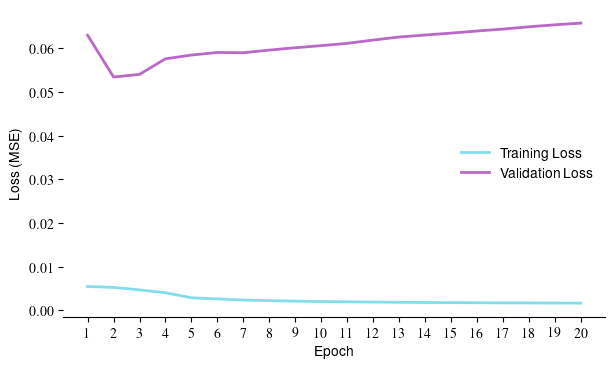

In [8]:
# Plot Losses, Training and Validation
print(history.history)

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'monospace', 'monospace':['Andale Mono']})
rc('text', usetex=True)

# data
x = np.arange(1, len(history.history["loss"])+1)
y1 = history.history["loss"]
y2 = history.history["val_loss"]

# plot
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(x, y1, linewidth=2, color='#80DEEA', label="Training Loss")
ax.plot(x, y2, linewidth=2, color='#BA68C8', label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
# fig.suptitle("Model Loss")
ax.set_xticks(x)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False)

plt.show()

In [9]:
# Test the model and plot predictions

test_eval = model.evaluate(test_dataset, return_dict=True)
test_predictions = model.predict(test_dataset)
# test_predictions_unscaled = scaler.inverse_transform(test_predictions)

print(test_predictions.shape)
print(y_test.shape)

indx = -test_predictions.shape[0]
# print(test_predictions_unscaled, test_predictions.shape)
# print(test_eval)

2024-11-19 18:02:44.346227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [3650,1]
	 [[{{node Placeholder/_20}}]]
2024-11-19 18:02:44.346521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


10/10 [==============================] - 3s 317ms/step - loss: 0.0566 - mae: 0.2171


2024-11-19 18:02:47.728522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-19 18:02:47.729246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-19 18:02:47.729882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 3s 313ms/step
(2556, 1)
(3650, 1)


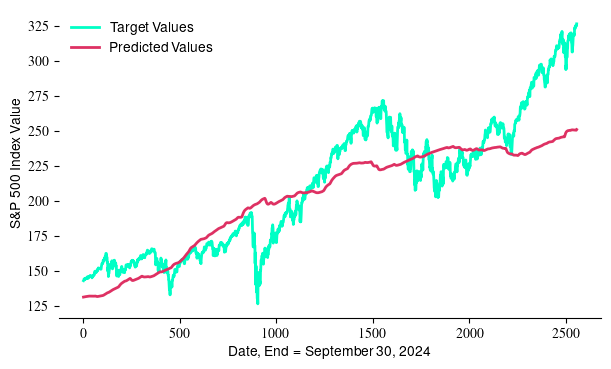

In [10]:
# Outputs
targets = scaler.inverse_transform(y_test)[indx:]
preds = scaler.inverse_transform(test_predictions)

# Make Prediction Plot, Traning and Validation

# data
x = np.arange(1, len(targets)+1).reshape(-1, 1)
y1 = targets[indx:]
y2 = preds


# plot
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(x, y1, linewidth=2, color='#00FFC5', label="Target Values")
ax.plot(x, y2, linewidth=2, color='#DE3163', label="Predicted Values")
ax.set_xlabel("Date, End = September 30, 2024")
ax.set_ylabel("S\&P 500 Index Value")
# fig.suptitle("Prediction Results, LSTM Model for S\&P 500")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False)

plt.show()



(2556, 1)
(24014,) 2556 (21458, 1)
(2556, 1) (21458, 1)
(24014,) (24014, 1) (24014, 1) (24014, 1)


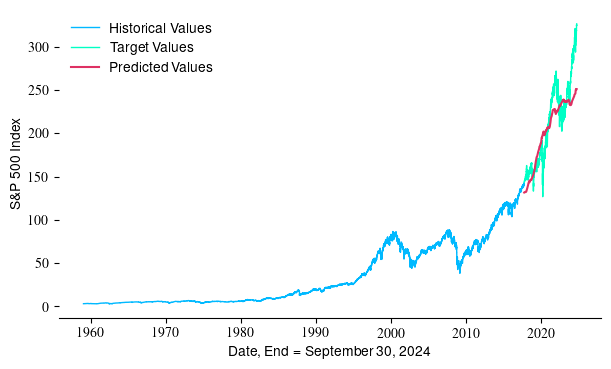

In [11]:

# Outputs
targets = scaler.inverse_transform(y_test)[indx:]
preds = scaler.inverse_transform(test_predictions)
print(preds.shape)

original = df['Close Norm'][:-targets.shape[0]].to_numpy().reshape(-1, 1)
print(df["Close Norm"].shape, targets.shape[0], df['Close Norm'][:-targets.shape[0]].to_numpy().reshape(-1, 1).shape)
nan_array_org = np.full(preds.shape[0], np.nan).reshape(-1, 1)
nan_array = np.full(original.shape[0], np.nan).reshape(-1, 1)
print(nan_array_org.shape, nan_array.shape)

original_nan = np.concatenate((original, nan_array_org))
preds_nan = np.concatenate((nan_array, preds))
targets_nan = np.concatenate((nan_array, targets))

# data
# x = np.arange(1, len(preds_nan)+1).reshape(-1, 1)
x = df.index
y1 = original_nan
y2 = preds_nan
y3 = targets_nan

print(x.shape, y1.shape, y2.shape, y3.shape)

# plot
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(x, y1, linewidth=1, color='#00B9FF', label="Historical Values")
ax.plot(x, y3, linewidth=1, color='#00FFC5', label="Target Values")
ax.plot(x, y2, linewidth=1.5, color='#DE3163', label="Predicted Values")

ax.set_xlabel("Date, End = September 30, 2024")
ax.set_ylabel("S\&P 500 Index")
# fig.suptitle("Prediction vs Targets of S\&P 500 Model")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False)

plt.show()

In [12]:
# Error Calculations
mse_test = round(np.mean((targets - preds)**2), 5)
mae_test = round(np.mean(abs(targets - preds)), 5)
mape_test = round(100*np.mean(abs((targets - preds)/targets)), 1)

print(f"LSTM Deep Learning Model\nMSE: {mse_test}\nMAE: {mae_test}\nMAPE: {mape_test}%")

pred_df = pd.DataFrame({'Target Values': targets.reshape(-1), 'LSTM Predictions': preds.reshape(-1), 'Date': df.index[-len(targets):]})
pred_df["MAPE"] = 100*abs(pred_df["LSTM Predictions"]-pred_df["Target Values"])/pred_df["Target Values"]
pred_df["APE"] = 100*(pred_df["LSTM Predictions"]-pred_df["Target Values"])/pred_df["Target Values"]

pred_df.to_csv("data_output/LSTM_preds_vs_targets.csv")

LSTM Deep Learning Model
MSE: 662.83498
MAE: 19.75187
MAPE: 9.0%
